# Learning from Failures

Given the many executions we can generate, it is only natural that these executions would also be subject to _machine learning_ in order to learn which features of the input (or the execution) would be associated with failures.

In this chapter, we study the _Alhazen_ approach, one of the first of this kind.
Alhazen by Kampmann et al. \cite{Kampmann2020} automatically learns the associations between the failure of a program and _features of the input data_, say "The error occurs whenever the `<expr>` element is negative"

This chapter is based on an Alhazen implementation contributed by [Martin Eberlein](https://martineberlein.github.io) of TU Berlin. Thanks a lot, Martin!

In [117]:
# from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* This chapter extends the ideas from [the chapter on Generalizing Failure Circumstances](DDSetDebugger.ipynb).

In [118]:
import bookutils.setup

## Synopsis

<!-- Automatically generated. Do not edit. -->


## Machine Learning for Automated Debugging

When diagnosing why a program fails, the first step is to determine the circumstances under which the program fails.
In past chapters, we have examined approaches that [correlate execution features with failures](StatisticalDebugger.ipynb)
as well as tools that systematically _generate inputs_ to [reduce failure-inducing inputs](DeltaDebugger.ipynb) or [generalize failure circumstances](DDSetDebugger.ipynb).
In this chapter, we will go one step further and make use of full-fledged _machine learning_ to identify failure circumstances (and causes).

### The Alhazen Approach

In 2020, Kampmann et al. \cite{Kampmann2020} presented one of the first approaches to automatically learn circumstances of (failing) program behavior.
Their approach associates the program’s failure with the _syntactical features_ of the input data, allowing them to learn and extract the properties that result in the specific behavior.

Their reference implementation _Alhazen_ can generate a diagnosis and explain why, for instance, a particular bug occurs.
Alhazen forms a hypothetical model based on the observed inputs.
Additional test inputs are generated and executed to refine or refute the hypothesis, eventually obtaining a prediction model of the circumstances of why the behavior in question takes place.

The tool is named after [Ḥasan Ibn al-Haytham](https://en.wikipedia.org/wiki/Ibn_al-Haytham) (latinized name: Alhazen).
Often referred to as the "Father of modern optics", Ibn al-Haytham made significant contributions to the principles of optics and visual perception.
Most notably, he was an early proponent of the concept that a hypothesis must be supported by experiments, and thus
one of the inventors of the _scientific method_, the key process in the Alhazen tool.


![title](PICS/Alhazen.png)

Let us give a high-level description of how Alhazen works, illustrated above.

Alhazen is given an _input grammar_ and a number of _input files_ (whose format is given by the grammar),
and produces a _decision tree_ – a machine learning model that explains under which circumstances the program fails.

Alhazen determines and refines these decision trees in five steps:

1. For each input file, Alhazen extracts a number of _input features_ that apply.
   These input features are predicates over the individual elements of the input grammar, such as `<expr> > 0` (an `<expr>` element is larger than zero) or `exists(<minus-sign>)` (the input contains a minus sign).
2. The test outcomes of the input files _label_ these input files as _buggy_ or _non-buggy_.
   From the respective input features and the labels, Alhazen trains a _decision tree_ that associates these features with the labels - that is, the decision tree explains which features lead to _buggy_ or _non-buggy_.
3. As it is typically trained on few samples only, the initial classification model may be imprecise.
   Hence, Alhazen extracts further _requirements_ for additional test cases that may help in increasing precision, such as `<digit> == '6'` (we need more inputs in which the `<digit>` field has a value of `6`.)
4. Satisfying these requirements, Alhazen then generates additional inputs...
5. ...which it executes, thus again labeling them as _buggy_ or _non-buggy_.
   From the new inputs, we can again extract the features, and repeat the cycle.

The whole process keeps on refining decision trees with more and more inputs.
Eventually, the decision trees are supposed to be precise enough that they can become _theory_ - that is, an explanation of why the program fails with high predictive power for future inputs.

The Alhazen process thus automates the _scientific method of debugging_:

* making initial _observations_ (Steps 1 and 2),
* coming up with _hypotheses_ that explain the observations (Step 3),
* designing _experiments_ to further _support_ or _refute_ the hypotheses (Steps 4 and 5),
* and repeating the entire process until we have a _predicting theory_ on why the program fails.

### Structure of this Chapter

In the remainder of this chapter, we will first introduce [grammars](#Inputs-and-Grammars).

We then explore and implement the individual steps of Alhazen:

* [Step 1: Extracting Features](#Step-1:-Extracting-Features)
* [Step 2: Train Classification Model](#Step-2:-Train-Classification-Model)
* [Step 3: Extract Feature Requirements](#Step-3:-Extract-Feature-Requirements)
* [Step 4: Generating New Samples](#Step-4:-Generating-New-Samples)
* [Step 5: Executing New Inputs](#Step-5:-Generating-New-Inputs)

After this is done, we can compose all these into a single `Alhazen` class and [run it on a sample input](#A-Sample-Run).
If you want to see Alhazen in action first (before going into all the details, check out the sample run.)

## Inputs and Grammars

Alhazen heavily builds on _grammars_ as a means to decompose inputs into individual elements, such that it can reason about these elements, and also generate new ones automatically.

To work with grammars, we use the framework provided by [The Fuzzing Book](https://www.fuzzingbook.org).
For a more detailed description of Grammars and how to use them for production, have a look at the chapter ["Fuzzing with Grammars"](https://www.fuzzingbook.org/html/Grammars.html)

In [119]:
from typing import List, Tuple, Dict, Any, Optional

In [120]:
from fuzzingbook.Grammars import Grammar, EXPR_GRAMMAR, reachable_nonterminals, is_valid_grammar
from fuzzingbook.GrammarFuzzer import GrammarFuzzer, expansion_to_children, DerivationTree, tree_to_string, display_tree, is_nonterminal
from fuzzingbook.Parser import EarleyParser

Let us build a simple grammar for a calculator.
The calculator code is listed below.

In [121]:
from math import tan as rtan
from math import cos as rcos
from math import sin as rsin

In [122]:
"""
This file contains the code under test for the example bug.
The sqrt() method fails on x <= 0.
"""
def task_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    if x <= -12 and x >= -42:
        x = 0  # Guess where the bug is :-)
    else:
        x = 1
    x = max(x, 0)
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx


def task_tan(x):
    return rtan(x)


def task_cos(x):
    return rcos(x)


def task_sin(x):
    return rsin(x)



The language consists of functions (`<function>`) that are being invoked on a numerical value (`<term>`).

In [123]:
CALC_GRAMMAR: Grammar = {
    "<start>":
        ["<function>(<term>)"],

    "<function>":
        ["sqrt", "tan", "cos", "sin"],

    "<term>": ["-<value>", "<value>"],

    "<value>":
        ["<integer>.<digits>",
         "<integer>"],

    "<integer>":
        ["<lead-digit><digits>", "<digit>"],

    "<digits>":
        ["<digit><digits>", "<digit>"],

    "<lead-digit>":  # First digit cannot be zero
        ["1", "2", "3", "4", "5", "6", "7", "8", "9"],

    "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
}

We see that the `CALC_GRAMMAR` consists of several production rules. The calculator subject will only accept inputs that conform to this grammar definition.

Let us load two initial input samples:
- `sqrt(-16)`
- `sqrt(4)`

In [124]:
# Load initial input files
initial_sample_list = ['sqrt(-16)', 'sqrt(4)']

Let's execute our two input samples and observe the calculator's behavior.
We implement the function `sample_runner(sample)` that lets us execute the calculator for a single sample. `sample_runner(sample)` returns an `OracleResult` for the sample.

In [125]:
from enum import Enum

In [126]:
class OracleResult(Enum):
    BUG = "BUG"
    NO_BUG = "NO_BUG"
    UNDEF = "UNDEF"

    def __str__(self):
        return self.value

In [127]:
import sys

In [128]:
SUBJECT = "calculator"

def sample_runner(sample):
    testcode = sample

    try:
        # Simply execute the calculator code, with the functions replaced
        exec(testcode, {"sqrt": task_sqrt, "tan": task_tan, "sin": task_sin, "cos": task_cos}, {})
        return OracleResult.NO_BUG
    except ZeroDivisionError:
        return OracleResult.BUG
    except Exception as e:
        print(e, file=sys.stderr)
        return OracleResult.UNDEF

Let's test the function:

In [129]:
sample = "sqrt(-16)"
sample_runner(sample)

<OracleResult.BUG: 'BUG'>

As expected, the sample `sqrt(-16)` triggers the calculator bug. Let's try some more samples:

In [130]:
assert sample_runner("sqrt(-23)") == OracleResult.BUG
assert sample_runner("sqrt(44)") == OracleResult.NO_BUG
assert sample_runner("cos(-9)") == OracleResult.NO_BUG

What happens if we parse inputs to calculator that do not conform to its input format?

In [131]:
sample_runner("undef_function(QUERY)")

name 'undef_function' is not defined


<OracleResult.UNDEF: 'UNDEF'>

The function `sample_runner(sample)` returns an `OracleResult.UNDEF` whenever the runner is not able to execute the sample.

Finally, we provide the function `execute_samples(sample_list)` that obtains the oracle/label for a list of samples.
We use the `pandas` module to place these in a data frame.

In [132]:
import pandas
import numpy
import matplotlib

In [133]:
# Executes a list of samples and return the execution outcome (label)
# The function returns a pandas dataframe
def execute_samples(sample_list):
    data = []
    for sample in sample_list:
        result = sample_runner(sample)
        data.append({"oracle": result })

    return pandas.DataFrame.from_records(data)

Let us define a bigger list of samples to execute...

In [134]:
sample_list = ["sqrt(-20)", "cos(2)", "sqrt(-100)", "undef_function(foo)"]

... and obtain the execution outcome

In [135]:
labels = execute_samples(sample_list)
labels

name 'undef_function' is not defined


,oracle
0,BUG
1,NO_BUG
2,NO_BUG
3,UNDEF


We can combine these with the `sample_list`:

In [136]:
for i, row in enumerate(labels['oracle']): print(sample_list[i].ljust(30) + str(row))

sqrt(-20)                     BUG
cos(2)                        NO_BUG
sqrt(-100)                    NO_BUG
undef_function(foo)           UNDEF


We can remove the undefined input samples like this:

In [137]:
clean_data = labels.drop(labels[labels.oracle.astype(str) == "UNDEF"].index)
clean_data

,oracle
0,BUG
1,NO_BUG
2,NO_BUG


We can combine sample and labels by iterating over the obtained oracle:

In [138]:
oracle = execute_samples(sample_list)
for i, row in enumerate(oracle['oracle']):
    print(sample_list[i].ljust(30) + str(row))

sqrt(-20)                     BUG
cos(2)                        NO_BUG
sqrt(-100)                    NO_BUG
undef_function(foo)           UNDEF


name 'undef_function' is not defined


We observe that the sample `sqrt(-16)` triggers a bug in the calculator, whereas the sample `sqrt(4)` does not show unusual behavior. Of course, we want to know why the sample fails the program. In a typical use case, the developers of the calculator program would now try other input samples and evaluate if similar inputs also trigger the program's failure. Let's try some more input samples; maybe we can refine our understanding of why the calculator crashes:

Our guesses - maybe the failure is also in the `cos()` or `tan()` function?

In [139]:
guess_samples = ['cos(-16)', 'tan(-16)', 'sqrt(-100)', 'sqrt(-20.23412431234123)']

Let's obtain the execution outcome for each of our guesses:


In [140]:
guess_oracle = execute_samples(guess_samples)

Here come the results:

In [141]:
for i, row in enumerate(guess_oracle['oracle']):
    print(guess_samples[i].ljust(30) + str(row))

cos(-16)                      NO_BUG
tan(-16)                      NO_BUG
sqrt(-100)                    NO_BUG
sqrt(-20.23412431234123)      BUG


It looks like the failure only occurs in the `sqrt()` function, however, only for specific `x` values.
We could now try other values for `x` and repeat the process.
However, this would be highly time-consuming and not an efficient debugging technique for a larger and more complex test subject.

Wouldn't it be great if there was a tool that automatically does this for us? 
And this is exactly what _Alhazen_ is there for.
It helps us explain why specific input features cause a program to fail.

## Step 1: Extracting Features

In this section, we are concerned with the problem of extracting semantic features from inputs. In particular, Alhazen defines various features based on the input grammar, such as *existence* and *numeric interpretation*. These features are then extracted from the parse trees of the inputs (see Section 3 of \cite{Kampmann2020} for more details).

The implementation of the feature extraction module consists of the following three tasks:
1. Implementation of individual _feature classes_, whose instances allow deriving specific feature values from inputs
2. _Extraction of features from the grammar_ through instantiation of the aforementioned feature classes
3. Computation of _feature vectors_ from a set of inputs, which will then be used as input for the decision tree

### Internal and "Friendly" Feature Names

We use two kinds of _names_ for features:

* _internal_ names have the form `<SYMBOL>@N` and refer to the `N`-th expansion of symbol (starting with 0).
  In `CALC_GRAMMAR`, for instance, `<function>@0` refers to the expansion of `<function>` to `"sqrt"`
* _friendly_ names are more user-friendly (hence the name).
  The above feature `<function>@0` has the "friendly" name `<function> == "sqrt"`.

We use internal names in all our interaction with the machine learner, as they are unambiguous and do not contain whitespace.
When showing the final results, we switch to "friendly" names.

### Implementing Feature Classes

In [142]:
from abc import ABC, abstractmethod

In [143]:
class Feature(ABC):
    '''
    The abstract base class for grammar features.

    Args:
        name : A unique identifier name for this feature. Should not contain Whitespaces.
               e.g., 'type(<feature>@1)'
        rule : The production rule (e.g., '<function>' or '<value>').
        key  : The feature key (e.g., the chosen alternative or rule itself).
    '''

    def __init__(self, name: str, rule: str, key: str, /,
                 friendly_name: str = None) -> None:
        self.name = name
        self.rule = rule
        self.key = key
        self._friendly_name = friendly_name or name
        super().__init__()

    def __repr__(self) -> str:
        '''Returns a printable string representation of the feature.'''
        return self.name_rep()

    @abstractmethod
    def name_rep(self) -> str:
        pass

    def friendly_name(self) -> str:
        return self._friendly_name

    @abstractmethod
    def get_feature_value(self, derivation_tree) -> float:
        '''Returns the feature value for a given derivation tree of an input.'''
        pass

    def replace(self, new_key: str) -> 'Feature':
        '''Returns a new feature with the same name but a different key.'''
        return self.__class__(self.name, self.rule, new_key)

In [144]:
class ExistenceFeature(Feature):
    '''
    This class represents existence features of a grammar. Existence features indicate
    whether a particular production rule was used in the derivation sequence of an input.
    For a given production rule P -> A | B, a production existence feature for P and
    alternative existence features for each alternative (i.e., A and B) are defined.

    name : A unique identifier name for this feature. Should not contain Whitespaces.
           e.g., 'exist(<digit>@1)'
    rule : The production rule.
    key  : The feature key, equal to the rule attribute for production features,
           or equal to the corresponding alternative for alternative features.
    '''
    def __init__(self, name: str, rule: str, key: str,
                 friendly_name: str = None) -> None:
        super().__init__(name, rule, key, friendly_name=friendly_name)

    def name_rep(self) -> str:
        if self.rule == self.key:
            return f"exists({self.rule})"
        else:
            return f"exists({self.rule} == {self.key})"

    def get_feature_value(self, derivation_tree) -> float:
        '''Returns the feature value for a given derivation tree of an input.'''
        raise NotImplementedError

    def get_feature_value(self, derivation_tree: DerivationTree) -> float:
        '''Counts the number of times this feature was matched in the derivation tree.'''
        (node, children) = derivation_tree

        # The local match count (1 if the feature is matched for the current node, 0 if not)
        count = 0

        # First check if the current node can be matched with the rule
        if node == self.rule:

            # Production existance feature
            if self.rule == self.key:
                count = 1

            # Production alternative existance feature
            # We compare the children of the expansion with the actual children
            else:
                expansion_children = list(map(lambda x: x[0], expansion_to_children(self.key)))
                node_children = list(map(lambda x: x[0], children))
                if expansion_children == node_children:
                    count= 1

        # Recursively compute the counts for all children and return the sum for the whole tree
        for child in children:
            count = max(count, self.get_feature_value(child)) 

        return count

In [145]:
class NumericInterpretation(Feature):
    '''
    This class represents numeric interpretation features of a grammar. These features
    are defined for productions that only derive words composed of the characters
    [0-9], '.', and '-'. The returned feature value corresponds to the maximum
    floating-point number interpretation of the derived words of a production.

    name : A unique identifier name for this feature. Should not contain Whitespaces.
           e.g., 'num(<integer>)'
    rule : The production rule.
    '''
    def __init__(self, name: str, rule: str, /, 
                 friendly_name: str = None) -> None:
        super().__init__(name, rule, rule, friendly_name=friendly_name)

    def name_rep(self) -> str:
        return f"num({self.key})"

    def get_feature_value(self, derivation_tree) -> float:
        '''Returns the feature value for a given derivation tree of an input.'''
        raise NotImplementedError

    def get_feature_value(self, derivation_tree: DerivationTree) -> float:
        '''Determines the maximum float of this feature in the derivation tree.'''
        (node, children) = derivation_tree

        value = float('nan')
        if node == self.rule:
            try:
                #print(self.name, float(tree_to_string(derivation_tree)))
                value = float(tree_to_string(derivation_tree))
            except ValueError:
                #print(self.name, float(tree_to_string(derivation_tree)), "err")
                pass

        # Return maximum value encountered in tree, ignoring all NaNs
        tree_values = [value] + [self.get_feature_value(c) for c in children]
        if all(numpy.isnan(tree_values)):
            return value
        else:
            return numpy.nanmax(tree_values)

### Extracting Feature Sets from Grammars

In [146]:
def extract_existence_features(grammar: Grammar) -> List[ExistenceFeature]:
    '''
        Extracts all existence features from the grammar and returns them as a list.
        grammar : The input grammar.
    '''

    features = []

    for rule in grammar:
        # add the rule
        features.append(ExistenceFeature(f"exists({rule})", rule, rule))
        # add all alternatives
        for count, expansion in enumerate(grammar[rule]):
            name = f"exists({rule}@{count})"
            friendly_name = f"{rule} == {repr(expansion)}"
            feature = ExistenceFeature(name, rule, expansion,
                                       friendly_name=friendly_name)
            features.append(feature)

    return features

In [147]:
from collections import defaultdict
import re

In [148]:
# Regex for non-terminal symbols in expansions
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

def extract_numeric_features(grammar: Grammar) -> List[NumericInterpretation]:
    '''
        Extracts all numeric interpretation features from the grammar and returns them as a list.

        grammar : The input grammar.
    '''

    features = []

    # Mapping from non-terminals to derivable terminal chars
    derivable_chars = defaultdict(set)

    for rule in grammar:
        for expansion in grammar[rule]:
            # Remove non-terminal symbols and whitespace from expansion
            terminals = re.sub(RE_NONTERMINAL, '', expansion).replace(' ', '')

            # Add each terminal char to the set of derivable chars
            for c in terminals:
                derivable_chars[rule].add(c)

    # Repeatedly update the mapping until convergence
    while True:
        updated = False
        for rule in grammar:
            for r in reachable_nonterminals(grammar, rule):
                before = len(derivable_chars[rule])
                derivable_chars[rule].update(derivable_chars[r])
                after = len(derivable_chars[rule])

                # Set of derivable chars was updated
                if after > before:
                    updated = True

        if not updated:
            break

    numeric_chars = set(['0','1','2','3','4','5','6','7','8','9','.','-'])

    for key in derivable_chars:
        # Check if derivable chars contain only numeric chars
        if len(derivable_chars[key] - numeric_chars) == 0:
            name = f"num({key})"
            friendly_name = f"{key}"

            features.append(NumericInterpretation(f"num({key})", key,
                                                  friendly_name=friendly_name))

    return features

In [149]:
def extract_all_features(grammar: Grammar) -> List[Feature]:
    return (extract_existence_features(grammar)
            + extract_numeric_features(grammar))

Here are all the features from our calculator grammar:

In [150]:
extract_all_features(CALC_GRAMMAR)

[exists(<start>),
 exists(<start> == <function>(<term>)),
 exists(<function>),
 exists(<function> == sqrt),
 exists(<function> == tan),
 exists(<function> == cos),
 exists(<function> == sin),
 exists(<term>),
 exists(<term> == -<value>),
 exists(<term> == <value>),
 exists(<value>),
 exists(<value> == <integer>.<digits>),
 exists(<value> == <integer>),
 exists(<integer>),
 exists(<integer> == <lead-digit><digits>),
 exists(<integer> == <digit>),
 exists(<digits>),
 exists(<digits> == <digit><digits>),
 exists(<digits> == <digit>),
 exists(<lead-digit>),
 exists(<lead-digit> == 1),
 exists(<lead-digit> == 2),
 exists(<lead-digit> == 3),
 exists(<lead-digit> == 4),
 exists(<lead-digit> == 5),
 exists(<lead-digit> == 6),
 exists(<lead-digit> == 7),
 exists(<lead-digit> == 8),
 exists(<lead-digit> == 9),
 exists(<digit>),
 exists(<digit> == 0),
 exists(<digit> == 1),
 exists(<digit> == 2),
 exists(<digit> == 3),
 exists(<digit> == 4),
 exists(<digit> == 5),
 exists(<digit> == 6),
 exists(<

The `friendly` representation is a bit more concise and more readable:

In [151]:
[f.friendly_name() for f in extract_all_features(CALC_GRAMMAR)]

['exists(<start>)',
 "<start> == '<function>(<term>)'",
 'exists(<function>)',
 "<function> == 'sqrt'",
 "<function> == 'tan'",
 "<function> == 'cos'",
 "<function> == 'sin'",
 'exists(<term>)',
 "<term> == '-<value>'",
 "<term> == '<value>'",
 'exists(<value>)',
 "<value> == '<integer>.<digits>'",
 "<value> == '<integer>'",
 'exists(<integer>)',
 "<integer> == '<lead-digit><digits>'",
 "<integer> == '<digit>'",
 'exists(<digits>)',
 "<digits> == '<digit><digits>'",
 "<digits> == '<digit>'",
 'exists(<lead-digit>)',
 "<lead-digit> == '1'",
 "<lead-digit> == '2'",
 "<lead-digit> == '3'",
 "<lead-digit> == '4'",
 "<lead-digit> == '5'",
 "<lead-digit> == '6'",
 "<lead-digit> == '7'",
 "<lead-digit> == '8'",
 "<lead-digit> == '9'",
 'exists(<digit>)',
 "<digit> == '0'",
 "<digit> == '1'",
 "<digit> == '2'",
 "<digit> == '3'",
 "<digit> == '4'",
 "<digit> == '5'",
 "<digit> == '6'",
 "<digit> == '7'",
 "<digit> == '8'",
 "<digit> == '9'",
 '<term>',
 '<value>',
 '<lead-digit>',
 '<digit>',


### Extracting Feature Values from Inputs

This is a rather slow implementation.
For many grammars with many syntactically features, the feature collection can be optimized.

In [152]:
def collect_features(sample_list: List[str],
                     grammar: Grammar) -> pandas.DataFrame:

    data = []

    # parse grammar and extract features
    all_features = extract_all_features(grammar)

    # iterate over all samples
    for sample in sample_list:
        parsed_features = {}
        parsed_features["sample"] = sample
        # initate dictionary
        for feature in all_features:
            parsed_features[feature.name] = 0

        # Obtain the parse tree for each input file
        earley = EarleyParser(grammar)
        for tree in earley.parse(sample):

            for feature in all_features:
                parsed_features[feature.name] = feature.get_feature_value(tree)

        data.append(parsed_features)

    return pandas.DataFrame.from_records(data)

In [153]:
sample_list = ["sqrt(-900)", "sin(24)", "cos(-3.14)"]
collect_features(sample_list, CALC_GRAMMAR)

,sample,exists(<start>),exists(<start>@0),exists(<function>),exists(<function>@0),exists(<function>@1),exists(<function>@2),exists(<function>@3),exists(<term>),exists(<term>@0),...,exists(<digit>@6),exists(<digit>@7),exists(<digit>@8),exists(<digit>@9),num(<term>),num(<value>),num(<lead-digit>),num(<digit>),num(<integer>),num(<digits>)
0,sqrt(-900),1,1,1,1,0,0,0,1,1,...,0,0,0,0,-900.00,900.00,9.0,0.0,900.0,0.0
1,sin(24),1,1,1,0,0,0,1,1,0,...,0,0,0,0,24.00,24.00,2.0,4.0,24.0,4.0
2,cos(-3.14),1,1,1,0,0,1,0,1,1,...,0,0,0,0,-3.14,3.14,NaN,4.0,3.0,14.0


In [154]:
# TODO: handle multiple trees
def compute_feature_values(sample: str, grammar: Grammar, features: List[Feature]) -> Dict[str, float]:
    '''
        Extracts all feature values from an input.

        sample   : The input.
        grammar  : The input grammar.
        features : The list of input features extracted from the grammar.

    '''
    earley = EarleyParser(CALC_GRAMMAR)

    features = {}
    for tree in earley.parse(sample):
        for feature in extract_all_features(CALC_GRAMMAR):
            features[feature.name_rep()] = feature.get_feature_value(tree)
    return features

In [155]:
all_features = extract_all_features(CALC_GRAMMAR)
for sample in sample_list:
    print(f"Features of {sample}:")
    features = compute_feature_values(sample, CALC_GRAMMAR, all_features)
    for feature, value in features.items():
        print(f"    {feature}: {value}")

Features of sqrt(-900):
    exists(<start>): 1
    exists(<start> == <function>(<term>)): 1
    exists(<function>): 1
    exists(<function> == sqrt): 1
    exists(<function> == tan): 0
    exists(<function> == cos): 0
    exists(<function> == sin): 0
    exists(<term>): 1
    exists(<term> == -<value>): 1
    exists(<term> == <value>): 0
    exists(<value>): 1
    exists(<value> == <integer>.<digits>): 0
    exists(<value> == <integer>): 1
    exists(<integer>): 1
    exists(<integer> == <lead-digit><digits>): 1
    exists(<integer> == <digit>): 0
    exists(<digits>): 1
    exists(<digits> == <digit><digits>): 1
    exists(<digits> == <digit>): 1
    exists(<lead-digit>): 1
    exists(<lead-digit> == 1): 0
    exists(<lead-digit> == 2): 0
    exists(<lead-digit> == 3): 0
    exists(<lead-digit> == 4): 0
    exists(<lead-digit> == 5): 0
    exists(<lead-digit> == 6): 0
    exists(<lead-digit> == 7): 0
    exists(<lead-digit> == 8): 0
    exists(<lead-digit> == 9): 1
    exists(<digit>)

### Excursion: Transforming Grammars

Alhazen requires grammars to be transformed, such that for each non-terminal symbol in the grammar, the word derived by this symbol in the input is added as an alternative to the symbol (as written in \cite{Kampmann2020}). Here, we iterate through the derivation tree of the input and add the derived word of each nonterminal as alternatives to the grammar.

In [156]:
import random

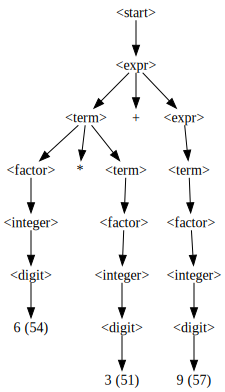

In [157]:
# For this example, fix the random seed so that the produced output is deterministic
random.seed(24)
f = GrammarFuzzer(EXPR_GRAMMAR, max_nonterminals=3)
test_input = f.fuzz()
assert(test_input == tree_to_string(f.derivation_tree))

display_tree(f.derivation_tree)

Let us write a function `transform_grammar()` that given a sample input and a grammar, transforms it according to Kampmann et al.

```python

def transform_grammar(sample: str,
                     grammar: Grammar) -> Grammar

```

The function requires the following input parameter:
- `sample`: an input sample 
- `grammar`: the grammar that should be transformed/extended

The function returns the transformed and extended grammar.

In [158]:
# Recursively iterate through the derivation tree and for each non-terminal,
# add the derived word to the grammar

def extend_grammar(derivation_tree, grammar):
    (node, children) = derivation_tree

    if is_nonterminal(node):
        assert(node in grammar)
        word = tree_to_string(derivation_tree)

        # Only add to grammar if not already existent
        if word not in grammar[node]:
            grammar[node].append(word)

    for child in children:
        extend_grammar(child, grammar)

In [159]:
import copy

In [160]:
def transform_grammar(sample: str,
                      grammar: Grammar) -> Grammar:
    # copy of the grammar
    transformed_grammar = copy.deepcopy(grammar)

    # parse sample
    earley = EarleyParser(grammar)
    for derivation_tree in earley.parse(sample):
        extend_grammar(derivation_tree, transformed_grammar)

    return transformed_grammar

Here is an example of a transformed grammar:

In [161]:
transformed_grammar = transform_grammar("1 + 2", EXPR_GRAMMAR)
for rule in transformed_grammar:
    print(rule.ljust(10), transformed_grammar[rule])

<start>    ['<expr>', '1 + 2']
<expr>     ['<term> + <expr>', '<term> - <expr>', '<term>', '1 + 2', '2']
<term>     ['<factor> * <term>', '<factor> / <term>', '<factor>', '1', '2']
<factor>   ['+<factor>', '-<factor>', '(<expr>)', '<integer>.<integer>', '<integer>', '1', '2']
<integer>  ['<digit><integer>', '<digit>', '1', '2']
<digit>    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### End of Excursion

## Step 2: Train Classification Model

Now that we have all the input features and the test outcomes, we can start training a machine learner from these.
Although other machine learning models have much higher accuracy, we use _decision trees_ as machine learning models because they are easy to interpret by humans.
This is crucial as it will be these very same humans that have to fix the code.

Before we start with our actual implementation, let us first illustrate how training such a classifier works, again using our calculator as an example.

### Decision Trees

We will use `scikit-learn` as the machine learning library.
The `DecisionTreeClassifier` can then learn the syntactical input features that are responsible for the bug-triggering behavior of our Calculator.

In [162]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

First, we transform the individual input features (represented as Python dictionaries) into a NumPy array.
For this example, we use the following four features (`function-sqrt`, `function-cos`, `function-sin`, `number`) to describe an input feature.
(Please note that this is an extremely reduced example; this is not the complete list of features that should be extracted from the `CALC_GRAMMAR` Grammar.)

The features `function-sqrt`, `function-cos`, `function-sin` state whether the function _sqrt_, _cos_, or _sin_ was used.
A `1` is given if the sample contains the respective function, otherwise the feature contains a `0`.

For each `<function>(x)`, the `number` feature describes which value was used for `x`. For instance, the first input `sqrt(-900)` corresponds to 'function-sqrt': 1 and 'number': -900.

In [163]:
# Features for each input, one dict per input
features = [
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': -900}, # sqrt(-900)
    {'function-sqrt': 0, 'function-cos': 1, 'function-sin': 0, 'number': 300}, # cos(300)
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': -1}, # sqrt(-1)
    {'function-sqrt': 0, 'function-cos': 1, 'function-sin': 0, 'number': -10}, # cos(-10)
    {'function-sqrt': 0, 'function-cos': 0, 'function-sin': 1, 'number': 36}, # sin(36)
    {'function-sqrt': 0, 'function-cos': 0, 'function-sin': 1, 'number': -58}, # sin(-58)
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': 27}, # sqrt(27)
]

We define a list of labels (or oracles) that state whether the specific input file resulted in a bug or not. We use the `OracleResult`-Class to keep everything tidy and clean.

In [164]:
# Labels for each input
oracle = [
    OracleResult.BUG,
    OracleResult.NO_BUG,
    OracleResult.BUG,
    OracleResult.NO_BUG,
    OracleResult.NO_BUG,
    OracleResult.NO_BUG,
    OracleResult.NO_BUG
]

# Transform to numpy array
vec = DictVectorizer()
X = vec.fit_transform(features).toarray()

Using the feature array and labels, we can now train a decision tree classifier as follows:

In [165]:
# Fix the random state to produce a deterministic result (for illustration purposes only)
clf = DecisionTreeClassifier(random_state=10)

# sci-kit learn requires an array of strings
oracle_clean = [str(c) for c in oracle]
clf = clf.fit(X, oracle_clean)

Let's have a look at the learned decision tree:

In [166]:
import graphviz

In [167]:
def show_decision_tree(clf, feature_names):
    dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                                    feature_names=feature_names,
                                    class_names=["BUG", "NO_BUG"],  
                                    filled=True, rounded=True)  
    return graphviz.Source(dot_data)

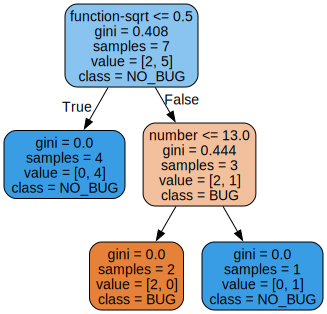

In [168]:
show_decision_tree(clf, vec.get_feature_names_out())

Here is a much reduced textual variant, still retaining the essential features:

In [169]:
import math

In [170]:
def friendly_decision_tree(clf, feature_names,
                           class_names = ['NO_BUG', 'BUG'],
                           indent=0):
    def _tree(index, indent):
        s = ""
        feature = clf.tree_.feature[index]
        feature_name = feature_names[feature]
        threshold = clf.tree_.threshold[index]
        value = clf.tree_.value[index]
        class_ = int(value[0][0])
        class_name = class_names[class_]
        left = clf.tree_.children_left[index]
        right = clf.tree_.children_right[index]
        if left == right:
            # Leaf node
            s += " " * indent + class_name + "\n"
        else:
            if math.isclose(threshold, 0.5):
                s += " " * indent + f"if {feature_name}:\n"
                s += _tree(right, indent + 2)
                s += " " * indent + f"else:\n"
                s += _tree(left, indent + 2)
            else:
                s += " " * indent + f"if {feature_name} <= {threshold:.4f}:\n"
                s += _tree(left, indent + 2)
                s += " " * indent + f"else:\n"
                s += _tree(right, indent + 2)
        return s

    ROOT_INDEX = 0
    return _tree(ROOT_INDEX, indent)

In [171]:
print(friendly_decision_tree(clf, vec.get_feature_names_out()))

if function-sqrt:
  if number <= 13.0000:
    BUG
  else:
    NO_BUG
else:
  NO_BUG



We can see that our initial hypothesis is that the feature `function-sqrt` must be greater than 0.5 (i.e., present) and the feature `number` must be less or equal than 13 in order to produce a bug. The decision rule is not yet perfect, thus we need to refine our decision tree!

### Learning a Decision Tree

For _Alhazen's_ second step (Train Classification Model), we write a function `train_tree(data)` that trains a decision tree on a given data frame:

```python

def train_tree(data: pandas.core.frame.DataFrame) -> sklearn.tree._classes.DecisionTreeClassifier

```

The function requires the following parameter:

- data: a `pandas` data frame containing the parsed and extracted features and the outcome of the executed input sample (oracle).

For instance, the data frame may look similar to this:

| feature_1     | feature_2     | ...    |oracle|
| ------------- |-------------|-------------|-----|
| 1     | 0 | ...| 'BUG' |
| 0     | 1 | ...| 'NO_BUG' |

**Note:** Each row of `data['oracle']` is of type `OracleResult`.
However, sci-kit learn requires an array of strings.
We have to convert them to learn the decision tree.

**OUTPUT**: the function returns a learned decision tree of type `_sklearn.tree._classes.DecisionTreeClassifier_`.

In [172]:
def train_tree(data):
    sample_bug_count = len(data[(data["oracle"].astype(str) == "BUG")])
    assert sample_bug_count > 0, "No bug samples found"
    sample_count = len(data)

    clf = DecisionTreeClassifier(min_samples_leaf=1,
                                     min_samples_split=2,  # minimal value
                                     max_features=None,
                                     max_depth=5, # max depth of the decision tree
                                     class_weight={str("BUG"): (1.0/sample_bug_count),
                                                   str("NO_BUG"):
                                                       (1.0/(sample_count - sample_bug_count))})
    clf = clf.fit(data.drop('oracle', axis=1), data['oracle'].astype(str))
    # MARTIN: This is optional, but is a nice extesion that results in nicer decision trees
    # clf = treetools.remove_infeasible(clf, features)
    return clf

## Step 3: Extract Feature Requirements

In this section, we will extract the learned features from the decision tree.
Again, let us first test this manually on our calculator example.

In [173]:
# Features for each input, one dict per input
features = [
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': -900},
    {'function-sqrt': 0, 'function-cos': 1, 'function-sin': 0, 'number': 300},
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': -1},
    {'function-sqrt': 0, 'function-cos': 1, 'function-sin': 0, 'number': -10},
    {'function-sqrt': 0, 'function-cos': 0, 'function-sin': 1, 'number': 36},
    {'function-sqrt': 0, 'function-cos': 0, 'function-sin': 1, 'number': -58},
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': 27},
]

# Labels for each input
oracle = [
    "BUG",
    "NO_BUG",
    "BUG",
    "NO_BUG",
    "NO_BUG",
    "NO_BUG",
    "NO_BUG"
]

# We can use the sklearn DictVectorizer to transform the features to numpy array:
# Notice: Use the correct labeling of the feature_names

# vec = DictVectorizer()
# X_vec = vec.fit_transform(features).toarray()
# feature_names = vec.get_feature_names_out()

# We can also use a pandas DataFrame and directly parse it to the decision tree learner
feature_names = ['function-sqrt', 'function-cos', 'function-sin', 'number']
X_data = pandas.DataFrame.from_records(features)

# Fix the random state to produce a deterministic result (for illustration purposes only)
clf = DecisionTreeClassifier(random_state=10)

# Train with DictVectorizer
# **Note:** The sklearn `DictVectorizer` uses an internal sort function as default. This will result in different feature_name indices. If you want to use the `Dictvectorizer` please ensure that you only access the feature_names with the function `vec.get_feature_names_out()`.
# We recommend that you use the `pandas` data frame, since this is also the format used in the feedback loop.
# clf = clf.fit(X_vec, oracle)

# Train with Pandas Dataframe
clf = clf.fit(X_data, oracle)

dot_data = sklearn.tree.export_graphviz(clf, out_file=None,
                                feature_names=feature_names,
                                class_names=["BUG", "NO BUG"],
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)

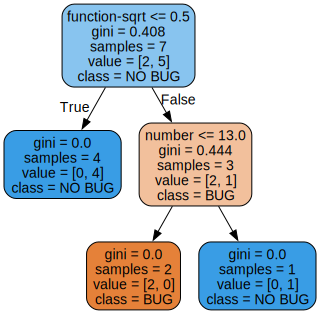

In [174]:
graph

In [175]:
print(friendly_decision_tree(clf, feature_names, class_names = ['NO_BUG', 'BUG']))

if function-sqrt:
  if number <= 13.0000:
    BUG
  else:
    NO_BUG
else:
  NO_BUG



### Excursion: Tree helper functions

We bundle several functions that are helpful when working with decision trees.

In [176]:
def all_path(clf, node=0):
    """Iterate over all path in a decision tree. Path will be represented as
    a list of integers, each integer is the index of a node in the clf.tree_ structure."""
    left = clf.tree_.children_left[node]
    right = clf.tree_.children_right[node]

    if left == right:
        yield [node]
    else:
        for path in all_path(clf, left):
            yield [node] + path
        for path in all_path(clf, right):
            yield [node] + path


def path_samples(clf, path):
    """Returns the number of samples for this path. """
    return clf.tree_.n_node_samples[path[-1]]


def generic_feature_names(clf):
    """Gives a list of feature names of the form f1, f2, ..."""
    return ["f{}".format(f) for f in range(0, clf.tree_.n_features)]


def box(clf, path, data=None, feature_names=None):
    """For a decision tree classifier clf and a path path (as returned, e.g. by all_path),
    this method gives a pandas DataFrame with the min and max of each feature value on the given path."""

    if feature_names is None:
        feature_names = generic_feature_names(clf)
    check_for_duplicates(feature_names)
    if data is None:
        bounds = pandas.DataFrame([{'feature': c, 'min': -numpy.inf, 'max': numpy.inf} for c in feature_names],
                                  columns=['feature', 'min', 'max']).set_index(['feature']).transpose()
    else:
        bounds = pandas.DataFrame([{'feature': c, 'min': data[c].min(), 'max': data[c].max()} for c in feature_names],
                                  columns=['feature', 'min', 'max']).set_index(['feature']).transpose()

    for pos in range(0, len(path) - 1):
        node = path[pos]
        child = path[pos + 1]
        feature = feature_names[clf.tree_.feature[node]]
        threshold = clf.tree_.threshold[node]

        if child == clf.tree_.children_left[node]:
            bounds.at['max', feature] = threshold
        else:
            bounds.at['min', feature] = threshold
    return bounds


def rectangles(clf, colormap, data, feature_names=None):
    """yields matplotlib.patches rectangle objects. Each object represents a leaf of the tree."""
    if feature_names is None:
        feature_names = ['in_x', 'in_y']
    if 2 != len(feature_names):
        raise AssertionError("Rectangles can only be generated if there are at most 2 features.")

    x_feature = feature_names[0]
    y_feature = feature_names[1]

    for path in all_path(clf):
        b = box(clf, path, data=data, feature_names=feature_names)
        p = prediction_for_path(clf, path)
        c = colormap[p]
        rect = matplotlib.patches.Rectangle((b[x_feature]['min'], 
                                             b[y_feature]['min']),
                             # coordinates
                             b[x_feature]['max'] - b[x_feature]['min'],  # width
                             b[y_feature]['max'] - b[y_feature]['min'],  # height
                             alpha=.2, facecolor=c, edgecolor='k')
        yield rect


def prediction_for_path(clf, path) -> OracleResult:
    last_value = clf.tree_.value[path[-1]][0]
    p_class = numpy.argmax(last_value)
    return OracleResult(clf.classes_[p_class])


def rule(clf, path, feature_names, class_names=None):
    """Creates a rule from one path in the decision tree."""
    bounds = box(clf, path, feature_names=feature_names)
    prediction = prediction_for_path(clf, path)
    if class_names is not None:
        prediction = class_names[prediction]

    feature_rules = []
    for fname in feature_names:
        min_ = bounds[fname]['min']
        max_ = bounds[fname]['max']

        if numpy.isinf(min_) and numpy.isinf(max_):
            pass  # no rule if both are unbound
        elif numpy.isinf(min_):
            feature_rules.append("{} <= {:.4f}".format(fname, max_))
        elif numpy.isinf(max_):
            feature_rules.append("{} > {:.4f}".format(fname, min_))
        else:
            feature_rules.append("{} in {:.4f} to {:.4f}".format(fname, min_, max_))

    return " AND ".join(feature_rules), prediction, clf.tree_.impurity[path[-1]], clf.tree_.n_node_samples[path[-1]]


def rules(clf, class_names=None, feature_names=None):
    """Formats Decision trees in a rule-like representation."""

    if feature_names is None:
        feature_names = generic_feature_names(clf)

    samples = clf.tree_.n_node_samples[0]
    return "\n".join(["IF {2} THEN PREDICT '{3}' ({0}: {4:.4f}, support: {5} / {1})"
                     .format(clf.criterion, samples,
                             *rule(clf, path, feature_names, class_names=class_names)) for path in all_path(clf)])


def grouped_rules(clf, class_names=None, feature_names=None):
    """Formats decision trees in a rule-like representation, grouped by class."""

    if feature_names is None:
        feature_names = generic_feature_names(clf)

    rules = {}
    for path in all_path(clf):
        rulestr, clz, impurity, support = rule(clf, path, class_names=class_names, feature_names=feature_names)
        if clz not in rules:
            rules[clz] = []
        rules[clz].append((rulestr, impurity, support))

    res = ""
    samples = clf.tree_.n_node_samples[0]
    for clz in rules:
        rulelist = rules[clz]
        res = res + "\n{}:\n\t".format(clz)
        rl = ["{} ({}: {:.4f}, support: {}/{})".format(r, clf.criterion, impurity, support, samples) for r, impurity, support in rulelist]
        res = res + "\n\tor ".join(rl)
    return res.lstrip()


def check_for_duplicates(names):
    seen = set()
    for name in names:
        if name in seen:
            raise AssertionError("Duplicate name: {}".format(name))
        seen.add(name)


def is_leaf(clf, node: int) -> bool:
    """returns true if the given node is a leaf."""
    return clf.tree_.children_left[node] == clf.tree_.children_right[node]


def leaf_label(clf, node: int) -> int:
    """returns the index of the class at this node. The node must be a leaf."""
    assert(is_leaf(clf, node))
    occs = clf.tree_.value[node][0]
    idx = 0
    maxi = occs[idx]
    for i, o in zip(range(0, len(occs)), occs):
        if maxi < o:
            maxi = o
            idx = i
    return idx


def find_existence_index(features: List[Feature], feature: Feature):
    for idx, f in enumerate(features):
        if isinstance(f, ExistenceFeature) and f.key() == feature.key():
            return idx
    raise AssertionError("There is no existence feature with this key!")


def remove_infeasible(clf, features: List[Feature]):
    for node in range(0, clf.tree_.node_count):
        if not is_leaf(clf, node):
            feature = features[clf.tree_.feature[node]]
            threshold = clf.tree_.threshold[node]
            if not feature.is_feasible(threshold):
                clf.tree_.feature[node] = find_existence_index(features, feature)
                clf.tree_.threshold[node] = 0.5
    return clf


def iterate_nodes(clf):
    stack = [0]
    while 0 != len(stack):
        node = stack.pop()
        yield node
        if not is_leaf(clf, node):
            stack.append(clf.tree_.children_left[node])
            stack.append(clf.tree_.children_right[node])


def count_nodes(clf):
    return len(list(iterate_nodes(clf)))


def count_leaves(clf):
    return len([n for n in iterate_nodes(clf) if is_leaf(clf, n)])


def list_features(clf):
    return [clf.tree_.feature[node] for node in iterate_nodes(clf)]


def remove_unequal_decisions(clf):
    """
    This method rewrites a decision tree classifier to remove nodes where the same
    decision is taken on both sides.

    :param clf: a decision tree classifier
    :return: the same classifier, rewritten
    """
    changed = True
    while changed:
        changed = False
        for node in range(0, clf.tree_.node_count):
            if not is_leaf(clf, node) and (is_leaf(clf, clf.tree_.children_left[node]) and is_leaf(clf, clf.tree_.children_right[node])):
                # both children of this node are leaves
                left_label = leaf_label(clf, clf.tree_.children_left[node])
                right_label = leaf_label(clf, clf.tree_.children_right[node])
                if left_label == right_label:
                    clf.tree_.children_left[node] = -1
                    clf.tree_.children_right[node] = -1
                    clf.tree_.feature[node] = -2
                    changed = True
                    assert(left_label == leaf_label(clf, node))
    return clf


### End of Excursion

### Excursion: Converting Trees to Paths

We bundle a number of helper functions that extract paths from trees.

In [177]:
class TreeRequirement:
    def __init__(self, feature: Feature, mini, maxi):
        self.__feature: Feature = feature
        self.__mini = mini
        self.__maxi = maxi

    def feature(self) -> Feature:
        return self.__feature

    def select(self, data):
        """Returns a vector of booleans, suitable for selecting in a pandas data frame."""
        if self.__mini is None:
            return data[self.__feature.name()] <= self.__maxi
        if self.__maxi is None:
            return self.__mini <= data[self.__feature.name()]
        return (self.__mini <= data[self.__feature.name()]) & (data[self.__feature.name()] <= self.__maxi)

    def mini(self):
        return self.__mini

    def maxi(self):
        return self.__maxi

    def get_key(self) -> str:
        return self.__feature.key()

    def is_binary(self) -> bool:
        return self.__feature.is_binary()

    def get_str(self, bounds) -> str:
        if self.is_binary():
            if self.__mini < 0 <= self.__maxi:
                # feature is NOT included
                return f"!{self.__feature.name()}"
            if self.__mini < 1 <= self.__maxi:
                # feature is included
                return self.__feature.name()
            raise AssertionError("How is this possible?")
        else:
            if (not numpy.isinf(self.__mini)) and (not numpy.isinf(self.__maxi)):
                return f"{self.__feature.name()} in [{self.__mini}, {self.__maxi}]"
            elif not numpy.isinf(self.__maxi):
                return f"{self.__feature.name()} <= {self.__maxi}"
            else:
                return f"{self.__feature.name()} > {self.__mini}"

    def get_str_ext(self) -> str:
        if (not numpy.isinf(self.__mini)) and (not numpy.isinf(self.__maxi)):
            return f"{self.__feature} in [{self.__mini}, {self.__maxi}]"
        elif not numpy.isinf(self.__maxi):
            return f"{self.__feature} <= {self.__maxi}"
        else:
            return f"{self.__feature} > {self.__mini}"

    def get_neg(self, bounds) -> List[str]:
        if self.is_binary():
            if self.__mini < 0 <= self.__maxi:
                # feature is NOT included, so, the negated condition is to include it
                return [self.__feature.name()]
            if self.__mini < 1 <= self.__maxi:
                # feature is included, so exclude it
                return [f"!{self.__feature.name()}"]
            raise AssertionError("How is this possible?")
        else:
            if (not numpy.isinf(self.__mini)) and (not numpy.isinf(self.__maxi)):
                return [f"{self.__feature.name()} in [{bounds.at['min', self.__feature.name()]},{self.__mini}]",
                        f"{self.__feature.name()} in [{self.__maxi}, {bounds.at['max', self.__feature.name()]}]"]
            elif not numpy.isinf(self.__maxi):
                return [f"{self.__feature.name()} <= {self.__maxi}"]
            else:
                return [f"{self.__feature.name()} > {self.__mini}"]

    def get_neg_ext(self, bounds) -> List[str]:
        if (not numpy.isinf(self.__mini)) and (not numpy.isinf(self.__maxi)):
            return [f"{self.__feature} in [{bounds.at['min', self.__feature]},{self.__mini}]",
                    f"{self.__feature} in [{self.__maxi}, {bounds.at['max', self.__feature]}]"]
        elif not numpy.isinf(self.__maxi):
            return [f"{self.__feature} > {self.__maxi}"]
        else:
            return [f"{self.__feature} <= {self.__mini}"]

In [178]:
from pathlib import Path

In [179]:
class TreePath:
    def __init__(self, samplefile: Optional[Path], is_bug: bool, requirements: List[TreeRequirement]):
        self.__sample = samplefile
        self.__is_bug = is_bug
        self.__requirements: List[TreeRequirement] = requirements

    def is_bug(self) -> bool:
        return self.__is_bug

    def get(self, idx):
        return self.__requirements[idx]

    def find_sample(self, data):
        for req in self.__requirements:
            data = data[req.select(data)]
        if 0 != len(data):
            return data["abs_file"][0]
        return None

    def __len__(self) -> int:
        return len(self.__requirements)


def lower_middle(start, end):
    if start == end:
        return start - abs(start)
    return start + ((end - start)/2)


def upper_middle(start, end):
    if start == end:
        return end + abs(end)
    return start + ((end - start)/2)


def min_digits(mini):
    return int("1" + "".join([0] * int(mini-1)))


def max_digits(maxi):
    return int("".join([9] * int(maxi)))

In [180]:
def tree_to_paths(tree, features: List[Feature]):
    paths = []
    # go through tree leaf by leaf
    for path in all_path(tree):
        requirements = []
        is_bug = OracleResult.BUG == prediction_for_path(tree, path)
        # find the requirements
        box_ = box(tree, path, feature_names=features).transpose()
        for feature, row in box_.iterrows():
            mini = row['min']
            maxi = row['max']
            if (not numpy.isinf(mini)) or (not numpy.isinf(maxi)):
                requirements.append(TreeRequirement(feature, mini, maxi))
        paths.append(TreePath(None, is_bug, requirements))

    return paths

In [181]:
# We provide a functionallity to extract the paths from a decision tree.
all_paths = tree_to_paths(clf, feature_names)

Here is an example:

In [182]:
for count, path in enumerate(all_paths):
    string_path = path.get(0).get_str_ext()
    for box_ in range(1, len(path)):
        string_path += " " + path.get(box_).get_str_ext()
    print(f"Path {count}: {string_path}, is_bug: {path.is_bug()}")

Path 0: function-sqrt <= 0.5, is_bug: False
Path 1: function-sqrt > 0.5 number <= 13.0, is_bug: True
Path 2: function-sqrt > 0.5 number > 13.0, is_bug: False


### End of Excursion

## Step 4: Generating New Samples

The next step is to generate new samples.
For this purpose, we _negate_ the requirements on a path to refine and refute the decision tree.

### Negating Requirements

First we will determine some boundaries to obtain better path negations.

In [183]:
x = pandas.DataFrame.from_records(features)
bounds = pandas.DataFrame([{'feature': c, 'min': x[c].min(), 'max': x[c].max()}
                           for c in feature_names],
                          columns=['feature', 'min', 'max']).set_index(['feature']).transpose()

We can use the function `path.get(i).get_neg_ext(bounds)` to obtain a negation for a single requirement on a path (indexed with `i`).

Let's verify if we can negate a whole path.

In [184]:
for count, path in enumerate(all_paths):
    negated_string_path = path.get(0).get_neg_ext(bounds)[0]
    for box_ in range(1, len(path)):
        negated_string_path += " " + str(path.get(box_).get_neg_ext(bounds)[0])
    print(f"Path {count}: {negated_string_path}, is_bug: {path.is_bug()}")

Path 0: function-sqrt > 0.5, is_bug: False
Path 1: function-sqrt <= 0.5 number > 13.0, is_bug: True
Path 2: function-sqrt <= 0.5 number <= 13.0, is_bug: False


### Systematically Negating Paths

We will use the Decision tree and extract new input specifications to refine or refute our hypothesis (See Section 4.1 "Extracting Prediction Paths" in \cite{Kampmann2020}).
These input specifications will be parsed to the input generator that tries to generate new inputs that fulfill the defined input specifications.

In [185]:
def extracting_prediction_paths(clf, feature_names, data):
    # determine the bounds
    bounds = pandas.DataFrame([{'feature': c, 'min': data[c].min(), 'max': data[c].max()}
                           for c in feature_names],
                          columns=['feature', 'min', 'max']).set_index(['feature']).transpose()

    # go through tree leaf by leaf
    all_reqs = set()
    for path in tree_to_paths(clf, feature_names):
        # generate conditions
        for i in range(0, len(path)+1):
            reqs_list = []
            bins = format(i, "#0{}b".format(len(path)+2))[2:]
            for p, b in zip(range(0, len(bins)), bins):
                r = path.get(p)
                if '1' == b:
                    reqs_list.append(r.get_neg_ext(bounds))
                else:
                    reqs_list.append([r.get_str_ext()])
            for reqs in all_combinations(reqs_list):
                all_reqs.add(", ".join(sorted(reqs)))
    return all_reqs

def all_combinations(reqs_lists):
    result = [[]]
    for reqs in reqs_lists:
        t = []
        for r in reqs:
            for i in result:
                t.append(i+[r])
        result = t
    return result

We will use the Decision tree and extract new input specifications to refine or refute our hypothesis (See paper Section 4.1 - Extracting Prediction Paths). These input specifications will be parsed to the input generator that tries to generate new inputs that fulfill the defined input specifications.

In [186]:
new_prediction_paths = extracting_prediction_paths(clf, feature_names, data=x)

In [187]:
for path in new_prediction_paths:
    print(path)

function-sqrt > 0.5, number <= 13.0
function-sqrt > 0.5, number > 13.0
function-sqrt > 0.5
function-sqrt <= 0.5, number > 13.0
function-sqrt <= 0.5, number <= 13.0
function-sqrt <= 0.5


### Input Specification Parser

Once we have input specifications, we must again extract them from the decision tree so we can interpret them.

In [188]:
import string

In [189]:
SPEC_GRAMMAR: Grammar = {
    "<start>":
        ["<req_list>"],

    "<req_list>": 
        ["<req>", "<req>"", ""<req_list>"],

    "<req>":
        ["<feature>"" ""<quant>"" ""<num>"],

    "<feature>": ["exists(<string>)",
                  "num(<string>)",
                  # currently not used
                  "char(<string>)",
                  "length(<string>)"],

    "<quant>":
        ["<", ">", "<=", ">="],

    "<num>": ["-<value>", "<value>"],

    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],

    '<string>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation)
}

assert is_valid_grammar(SPEC_GRAMMAR)

### Excursion: Validating the Parser

Let's validate our grammar, by using the grammar to produce 100 sample requirement specifications

In [190]:
g = GrammarFuzzer(SPEC_GRAMMAR, max_nonterminals=100)
earley = EarleyParser(SPEC_GRAMMAR)
for i in range(10):
    sample = g.fuzz()
    print(sample)

char(o/vy) >= 7
exists(E) <= 822.9
length(VnMoy) > -6460.3, exists(T) > 6, num(b) >= -1.03
length(f) >= -7677, char(O:t) < -6
length(x`) <= 08
num(@) >= 1.695, exists(=7&) > 23
exists(rV) >= -5.9, exists(|) <= 6969.0
length(bd) >= 4.8
num(8) <= 44.870, length(8xz') <= 13
exists(H) >= 0.4, num(#) > 1, exists(Q) >= -600.19


In [191]:
g = GrammarFuzzer(SPEC_GRAMMAR, max_nonterminals= 100)
earley = EarleyParser(SPEC_GRAMMAR)
for i in range(100):
    sample = g.fuzz()
    for tree in earley.parse(sample):
        assert tree_to_string(tree) == sample, f"{tree_to_string(tree)} and {sample} are not equal"

Let's also try with some real requirement specifications:

In [192]:
earley = EarleyParser(SPEC_GRAMMAR)
teststrings = ['exists(<function>@0) > 0.5, exists(<term>@0) <= 0.5, exists(<value>@1) <= 0.5',
               'exists(<digit>@9) <= 0.5, exists(<function>@0) > 0.5, num(<term>) > 0.05000000074505806',
               'exists(<digit>@2) <= 0.5, exists(<function>@0) < 0.5, num(<term>) <= 0.05000000074505806',
               'exists(<function>@0) > 0.5, num(<term>) > -3965678.1875']
for count, sample in enumerate(teststrings):
    for tree in earley.parse(sample):
        assert tree_to_string(tree) == teststrings[count], \
        f"{tree_to_string(tree)} and {teststrings[count]} are not equal"

### End of Excursion

### Retrieving New input Specifications

The following classes represent requirements for the test cases to be generated.

In [193]:
class SpecRequirement:
    '''
    This class represents a requirement for a new input sample that should be generated.
    This class contains the feature that should be fullfiled (Feature), a quantifier
    ("<", ">", "<=", ">=") and a value. For instance exist(feature) >= 0.5 states that
    the syntactical existence feature should be used to produce a new input.

    feature  : Is the associated feature class
    quant    : The quantifier
    value    : The value of the requirement. Note that for existence features this value
                is allways between 0 and 1.
    '''

    def __init__(self, feature: Feature, quantificator, value):
        self.feature: Feature = feature
        self.quant = quantificator
        self.value = value

    def __str__(self):
        return f"Requirement({self.feature.name} {self.quant} {self.value})"

    def __repr__(self):
        return f"Requirement({self.feature.name}, {self.quant}, {self.value})"

    def friendly(self):
        def value(x):
            try:
                return float(x)
            except Exception:
                return None

        if isinstance(self.feature, ExistenceFeature):
            if value(self.value) > 0:
                return f"{self.feature.friendly_name()}"
            elif value(self.value) < 0:
                return f"not {self.feature.friendly_name()}"

        return f"{self.feature.friendly_name()} {self.quant} {self.value}"

In [194]:
class InputSpecification:
    '''
    This class represents a complete input specification of a new input. A input specification
    consists of one or more requirements.
    requirements  : Is a list of all requirements that must be used.
    '''

    def __init__(self, requirements: List[SpecRequirement]):
        self.requirements: List[SpecRequirement] = requirements

    def __str__(self):
        s = ", ".join(str(r) for r in self.requirements)
        return f"InputSpecification({s})"

    def friendly(self):
        return " and ".join(r.friendly() for r in self.requirements)

    def __repr__(self):
        return self.__str__()

In [195]:
def get_all_subtrees(derivation_tree, non_terminal):
    '''
    Iteratively returns a list of subtrees that start with a given non_terminal.
    '''

    subtrees = []
    (node, children) = derivation_tree

    if node == non_terminal:
        subtrees.append(derivation_tree)

    for child in children:
        subtrees = subtrees + get_all_subtrees(child, non_terminal)

    return subtrees

In [196]:
def create_new_input_specification(derivation_tree, all_features) -> InputSpecification:
    '''
    This function creates a new input specification for a parsed decision tree path.
    The input derivation_tree corresponds to a already negated path in the decision tree.
    '''

    requirement_list = []

    for req in get_all_subtrees(derivation_tree, '<req>'):
        feature_name = tree_to_string(get_all_subtrees(req, '<feature>')[0])
        quant = tree_to_string(get_all_subtrees(req, '<quant>')[0])
        value = tree_to_string(get_all_subtrees(req, '<num>')[0])

        feature_class = None
        for f in all_features:
            if f.name == feature_name:
                feature_class = f

        requirement_list.append(SpecRequirement(feature_class, quant, value))

    return InputSpecification(requirement_list)

In [197]:
def get_all_input_specifications(dec_tree,
                                 all_features: List[Feature],
                                 feature_names: List[str],
                                 data) -> List[InputSpecification]:
    '''
    Returns a complete list new input specification that were extracted from a learned decision tree.

    INPUT:
        - dec_tree       : The learned decision tree.
        - all_features   : A list of all features
        - feature_names  : The list of the feature names (feature.name)
        - data.          : The data that was used to learn the decision tree

    OUTPUT:
        - Returns a list of InputSpecifications
    '''
    prediction_paths = extracting_prediction_paths(dec_tree, feature_names, data)
    input_specifications = []

    # parse all extracted paths
    for r in prediction_paths:
        earley = EarleyParser(SPEC_GRAMMAR)
        try:
            for tree in earley.parse(r):
                input_specifications.append(create_new_input_specification(tree, all_features))
        except SyntaxError:
            # Catch Parsing Syntax Errors: num(<term>) in [-900, 0] will fail; Might fix later
            # For now, inputs following that form will be ignored
            pass

    return input_specifications

### Excursion: Testing Specifications

In [198]:
sample_prediction_paths = ['exists(<function>@0) > 0.5, num(<term>) <= -38244758.0',
                        'exists(<digit>@7) <= 0.5, exists(<function>@0) > 0.5, num(<term>) <= 0.05000000074505806',
                        'exists(<digit>) > 1.5, exists(<function>@0) > 0.5, num(<term>) <= 0.21850000321865082', 
                        'exists(<function>@0) > 0.5']

expected_input_specifications = ['InputSpecification(Requirement(exists(<function>@0) > 0.5), Requirement(num(<term>) <= -38244758.0))',
                                 'InputSpecification(Requirement(exists(<digit>@7) <= 0.5), Requirement(exists(<function>@0) > 0.5), Requirement(num(<term>) <= 0.05000000074505806))',
                                 'InputSpecification(Requirement(exists(<digit>) > 1.5), Requirement(exists(<function>@0) > 0.5), Requirement(num(<term>) <= 0.21850000321865082))',
                                 'InputSpecification(Requirement(exists(<function>@0) > 0.5))']

all_features = extract_all_features(CALC_GRAMMAR)

earley = EarleyParser(SPEC_GRAMMAR)
for count, sample in enumerate(sample_prediction_paths):
    for tree in earley.parse(sample):
        input_specification = create_new_input_specification(tree, all_features)
        assert str(input_specification) == expected_input_specifications[count], \
            f"{str(input_specification)} is not equal to {expected_input_specifications[count]}"

If no assertion is triggered, then everything seems to work.

### End of Excursion

We implement a _Grammar-Based Input Generator_ that generates new input samples from a List of `InputSpecifications`.
The input specifications are extracted from the decision tree boundaries in the previous Step 3: `RequirementExtraction`.

An `InputSpecification` consists of **1 to n** many predicates or requirements (e.g. `<feature> >= value`, or `num(<term>) <= 13`).
We generate a new input for each `InputSpecification`.
The new input fulfills all the given requirements of an `InputSpecification`.

For further details, please refer to Section 4.4 and 4.5 of \cite{Kampmann2020} and the Chapter [Efficient Grammar Fuzzing](https://www.fuzzingbook.org/html/GrammarFuzzer.html) in the Fuzzing Book.

We define a function `generate_samples()` with the following input parameters:
- `grammar`: the grammar used to produce new inputs (e.g. the CALCULATOR-Grammar)
- `new_input_specification`: a List of new inputs specifications (type `List[InputSpecification]`)
- `timeout`: a max time budget. Return the generated inputs when the time budget is exceeded.

The function returns a list of new inputs that are specified by the given input specifications.

In [199]:
import time
import copy
from copy import deepcopy
import random
from itertools import chain

In [200]:
def best_trees(forest, spec, grammar):
    samples = [tree_to_string(tree) for tree in forest]
    fulfilled_fractions= []
    for sample in samples:
        gen_features = collect_features([sample], grammar)

        # calculate percentage of fulfilled requirements (used to rank the sample)
        fulfilled_count = 0
        total_count = len(spec.requirements)
        for req in spec.requirements:
            # for now, interpret requirement(exists(<...>) <= number) as false and requirement(exists(<...>) > number) as true
            if isinstance(req.feature, ExistenceFeature):
                expected = 1.0 if req.quant == '>' or req.quant == '>=' else 0.0
                actual = gen_features[req.feature.name][0]
                if actual == expected:
                    fulfilled_count += 1
                else:
                    pass
                    # print(f'{req.feature} expected: {expected}, actual:{actual}')
            elif isinstance(req.feature, NumericInterpretation):
                expected_value = float(req.value)
                actual_value = gen_features[req.feature.name][0]
                fulfilled = False
                if req.quant == '<':
                    fulfilled = actual_value < expected_value
                elif req.quant == '<=':
                    fulfilled = actual_value <= expected_value
                elif req.quant == '>':
                    fulfilled = actual_value > expected_value
                elif req.quant == '>=':
                    fulfilled = actual_value >= expected_value

                if fulfilled:
                    fulfilled_count += 1
                else:
                    pass
                    # print(f'{req.feature} expected: {expected_value}, actual:{actual_value}')
        fulfilled_fractions.append(fulfilled_count / total_count)
        # print(f'Fraction of fulfilled requirements: {fulfilled_count / total_count}')
    max_frac = max(fulfilled_fractions)
    best_chosen = []
    if max_frac == 1.0:
        return True, forest[fulfilled_fractions.index(1.0)]

    for i, t in enumerate(forest):
        if fulfilled_fractions[i] == max_frac:
            best_chosen.append(t)
    return False, best_chosen


In [201]:
# well, not perfect and probably not very robust. but it works :)
def generate_samples_advanced(grammar: Grammar,
                     new_input_specifications: List[InputSpecification],
                     timeout: int) -> List[str]:

    # if there are no input specifications: generate some random samples
    if len(new_input_specifications) == 0:
        fuzzer = GrammarFuzzer(grammar)
        samples = [fuzzer.fuzz() for _ in range(100)]
        return samples

    final_samples = []
    each_spec_timeout = timeout / len(new_input_specifications)

    rhs_nonterminals = grammar.keys()# list(chain(*[nonterminals(expansion) for expansion in grammar[rule]]))

    fuzzer = GrammarFuzzer(grammar)

    for spec in new_input_specifications:
        done = False
        starttime = time.time()
        best_chosen = [fuzzer.fuzz_tree() for _ in range(100)]
        done, best_chosen = best_trees(best_chosen, spec, grammar)
        if done:
            final_samples.append(tree_to_string(best_chosen))

        while not done and time.time() - starttime < each_spec_timeout:
            # split in prefix, postfix and try to reach targets
            for tree in best_chosen:
                prefix_len = random.randint(1, 3)
                curr = tree
                valid = True
                for i in range(prefix_len):
                    nt, children = curr
                    poss_desc_idxs = []
                    for c_idx, c in enumerate(children):
                        s, _ = c
                        possible_descend = s in rhs_nonterminals
                        if possible_descend:
                            poss_desc_idxs.append(c_idx)
                    if len(poss_desc_idxs) < 1:
                        valid = False
                        break
                    desc = random.randint(0, len(poss_desc_idxs) - 1)
                    curr = children[poss_desc_idxs[desc]]
                if valid:
                    nt, _ = curr
                    for req in spec.requirements:
                        if isinstance(req.feature, NumericInterpretation) and nt == req.feature.key:
                            # hacky: generate a derivation tree for this numeric interpretation
                            hacky_grammar = copy.deepcopy(grammar)
                            hacky_grammar["<start>"] = [nt]
                            parser = EarleyParser(hacky_grammar)
                            try:
                                test = parser.parse(req.value)
                                x = list(test)[0]
                                _, s = x
                                # print(str(s[0]))
                                # replace curr in tree with this new tree
                                curr = s[0]
                            except SyntaxError:
                                pass
            done, best_chosen = best_trees(best_chosen, spec, grammar)
            if done:
                final_samples.append(tree_to_string(best_chosen))
        if not done:
            final_samples.extend([tree_to_string(t) for t in best_chosen])

    return final_samples

Here's another interesting generator function:

In [202]:
def generate_samples_random(grammar, new_input_specifications, num):
    f = GrammarFuzzer(grammar ,max_nonterminals=50, log=False)
    data = []
    for _ in range(num):
        new_input = f.fuzz()
        data.append(new_input)

    return data

In [203]:
GENERATE_SAMPLES = generate_samples_advanced

### Excursion: Some Tests

In [204]:
exsqrt = ExistenceFeature('exists(<function>@0)', '<function>', 'sqrt')
exdigit = ExistenceFeature('exists(<digit>)', '<digit>', '<digit>')

reqDigit = SpecRequirement(exdigit, '>', '0.5')
fbdDigit = SpecRequirement(exdigit, '<=', '0.5')

req0 = SpecRequirement(exsqrt, '>', '-6.0')
testspec0 = InputSpecification([req0, reqDigit])
req1 = SpecRequirement(exsqrt, '<=', '-6.0')
testspec1 = InputSpecification([req1, fbdDigit])

numterm = NumericInterpretation('num(<term>)', '<term>')
req2 = SpecRequirement(numterm, '<', '-31.0')
testspec2 = InputSpecification([req2, req0, reqDigit])

print('--generating samples--')
# samples = generate_samples(CALC_GRAMMAR, [testspec0, testspec1], 10)
samples = GENERATE_SAMPLES(CALC_GRAMMAR, [testspec2], 10)
samples

--generating samples--


['sqrt(-81743)']

### End of Excursion

## Step 5: Executing New Inputs

We are almost done! All that is left is putting the above pieces together and create a _loop_ around them.

### The Alhazen Class

We implement a class `Alhazen` that serves as main entry point for our approach.

In [205]:
class Alhazen:
    def __init__(self,
                 runner: Any,
                 grammar: Grammar,
                 initial_inputs: List[str], /,
                 verbose: bool = False,
                 max_iterations: int = 10,
                 generator_timeout: int = 10):
        self._initial_inputs = initial_inputs
        self._runner = runner
        self._grammar = grammar
        self._verbose = verbose
        self._max_iter = max_iterations
        self._previous_samples = None
        self._data = None
        self._trees = []
        self._generator_timeout = generator_timeout
        self._setup()

In [206]:
class Alhazen(Alhazen):
    def _setup(self):
        self._previous_samples = self._initial_inputs

        self._all_features = extract_all_features(self._grammar)
        self._feature_names = [f.name for f in self._all_features]
        if self._verbose:
            print("Features:", ", ".join(f.friendly_name()
                                         for f in self._all_features))

In [207]:
class Alhazen(Alhazen):
    def _add_new_data(self, exec_data, feature_data):
        joined_data = exec_data.join(feature_data.drop(['sample'], axis=1))

        # Only add valid data
        new_data = joined_data[(joined_data['oracle'] != OracleResult.UNDEF)]
        new_data = joined_data.drop(joined_data[joined_data.oracle.astype(str) == "UNDEF"].index)
        if 0 != len(new_data):
            if self._data is None:
                self._data = new_data
            else:
                self._data = pandas.concat([self._data, new_data], sort=False)

In [208]:
class Alhazen(Alhazen):
    def execute_samples(self, sample_list = None):
        if sample_list is None:
            sample_list = self._initial_inputs

        data = []
        for sample in sample_list:
            result = self._runner(sample)
            data.append({"oracle": result })

        return pandas.DataFrame.from_records(data)

In [209]:
class Alhazen(Alhazen):
    def run(self):
        for iteration in range(1, self._max_iter + 1):
            if self._verbose:
                print(f"\nIteration #{iteration}")
            self._iterate(self._previous_samples)

In [210]:
class Alhazen(Alhazen):
    def all_trees(self, /, prune: bool = True):
        trees = self._trees
        if prune:
            trees = [remove_unequal_decisions(tree) for tree in self._trees]
        return trees

    def last_tree(self, /, prune: bool = True):
        return self.all_trees(prune=prune)[-1]

In [211]:
class Alhazen(Alhazen):
    def _iterate(self, sample_list):
        # Run samples, obtain test outcomes
        exec_data = self.execute_samples(sample_list)

        # Step 1: Extract features from the new samples
        feature_data = collect_features(sample_list, self._grammar)

        # Combine the new data with the already existing data
        self._add_new_data(exec_data, feature_data)
        # display(self._data)

        # Step 2: Train the Decision Tree Classifier
        dec_tree = train_tree(self._data)
        self._trees.append(dec_tree)

        if self._verbose:
            print("  Decision Tree:")
            all_features = extract_all_features(self._grammar)
            all_feature_names = [f.friendly_name() for f in all_features]
            print(friendly_decision_tree(dec_tree, all_feature_names, indent=4))

        # Step 3: Extract new requirements from the tree
        new_input_specifications = get_all_input_specifications(dec_tree,
                                                self._all_features,
                                                self._feature_names,
                                                self._data.drop(['oracle'], axis=1))
        if self._verbose:
            print(f"  New input specifications:")
            for spec in new_input_specifications:
                print(f"    {spec.friendly()}")

        # Step 4: Generate new inputs according to the new input specifications
        new_samples = GENERATE_SAMPLES(self._grammar,
                                       new_input_specifications,
                                       self._generator_timeout)
        if self._verbose:
            print(f"  New samples:")
            print(f"    {', '.join(new_samples)}")

        self._previous_samples = new_samples

In [212]:
class Alhazen(Alhazen):
    def all_feature_names(self, friendly: bool = True) -> List[str]:
        if friendly:
            all_feature_names = [f.friendly_name() for f in self._all_features]
        else:
            all_feature_names = [f.name for f in self._all_features]
        return all_feature_names

In [213]:
class Alhazen(Alhazen):
    def show_decision_tree(self, tree = None, friendly: bool = True):
        return show_decision_tree(tree or self.last_tree(),
                                  self.all_feature_names())

In [214]:
class Alhazen(Alhazen):
    def friendly_decision_tree(self, tree = None):
        return friendly_decision_tree(tree or self.last_tree(),
                                      self.all_feature_names())

## A Sample Run

We can finally run _Alhazen_!

Set the number of refinement iterations and the timeout for the input generator.
The execution time of Alhazen mainly depends on the number of iterations.

In [215]:
MAX_ITERATIONS = 20
GENERATOR_TIMEOUT = 10 # timeout in seconds

We initialize Alhazen with the previously used `initial_sample_list`:

In [216]:
initial_sample_list

['sqrt(-16)', 'sqrt(4)']

And here we go! When initialized with `verbose=True`, Alhazen prints its progress during execution, issuing for each iteration

* the last decision tree
* the new input specification resulting from the tree
* the new samples satisfying the input specification.

In [217]:
alhazen = Alhazen(sample_runner, CALC_GRAMMAR, initial_sample_list,
                  verbose=True,
                  max_iterations=MAX_ITERATIONS,
                  generator_timeout=GENERATOR_TIMEOUT)
alhazen.run()

Features: exists(<start>), <start> == '<function>(<term>)', exists(<function>), <function> == 'sqrt', <function> == 'tan', <function> == 'cos', <function> == 'sin', exists(<term>), <term> == '-<value>', <term> == '<value>', exists(<value>), <value> == '<integer>.<digits>', <value> == '<integer>', exists(<integer>), <integer> == '<lead-digit><digits>', <integer> == '<digit>', exists(<digits>), <digits> == '<digit><digits>', <digits> == '<digit>', exists(<lead-digit>), <lead-digit> == '1', <lead-digit> == '2', <lead-digit> == '3', <lead-digit> == '4', <lead-digit> == '5', <lead-digit> == '6', <lead-digit> == '7', <lead-digit> == '8', <lead-digit> == '9', exists(<digit>), <digit> == '0', <digit> == '1', <digit> == '2', <digit> == '3', <digit> == '4', <digit> == '5', <digit> == '6', <digit> == '7', <digit> == '8', <digit> == '9', <term>, <value>, <lead-digit>, <digit>, <integer>, <digits>

Iteration #1
  Decision Tree:
    if <digits> <= nan:
      BUG
    else:
      NO_BUG

  New input s

To access the final decision tree learned by Alhazen, use:

In [218]:
alhazen.last_tree()

DecisionTreeClassifier(class_weight={'BUG': 0.010638297872340425,
                                     'NO_BUG': 0.0005595970900951316},
                       max_depth=5)

Let's display it:

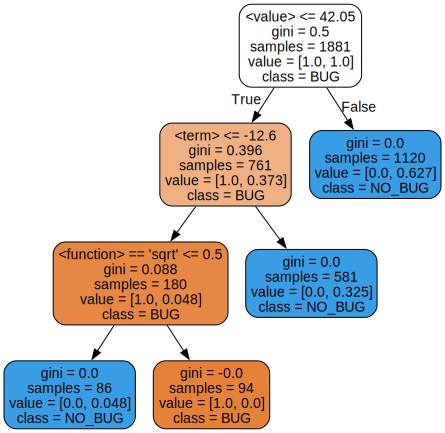

In [219]:
alhazen.show_decision_tree()

We can also view the tree as text:

In [220]:
print(alhazen.friendly_decision_tree())

if <value> <= 42.0500:
  if <term> <= -12.6000:
    if <function> == 'sqrt':
      BUG
    else:
      NO_BUG
  else:
    NO_BUG
else:
  NO_BUG



In both views, we see that the failure is related to the `sqrt()` function being called with a negative value.
But what's the deal with the `<lead-digit>` and `<value>` fields?
For this, let's have a look at our sqrt function code:

In [221]:
import inspect

In [222]:

print(inspect.getsource(task_sqrt))

def task_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    if x <= -12 and x >= -42:
        x = 0  # Guess where the bug is :-)
    else:
        x = 1
    x = max(x, 0)
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx



We see that Alhazen has correctly determined the boundaries of `x` for the bug - the `<lead-digit>` value must be `4` or less (otherwise, the value of `x` will not trigger the bug); and `<value>` and `<term>` correctly reflect the boundaries.
(Note that `<term>` comes with a sign, whereas `<value>` has no sign.)
Not too bad for a machine learning approach :-)

## Synopsis

This chapter provides an implementation of the _Alhazen_ approach \cite{Kampmann2020}, which trains machine learning _classifiers_ from input features.
Given a test function, a grammar, and a set of inputs, the `Alhazen` class produces a decision tree that _characterizes failure circumstances_:

In [223]:
alhazen = Alhazen(sample_runner, CALC_GRAMMAR, initial_sample_list,
                  max_iterations=20)
alhazen.run()

The final decision tree can be accessed using `last_tree()`:

In [224]:
# alhazen.last_tree()

We can visualize the resulting decision tree using `Alhazen.show_decision_tree()`:

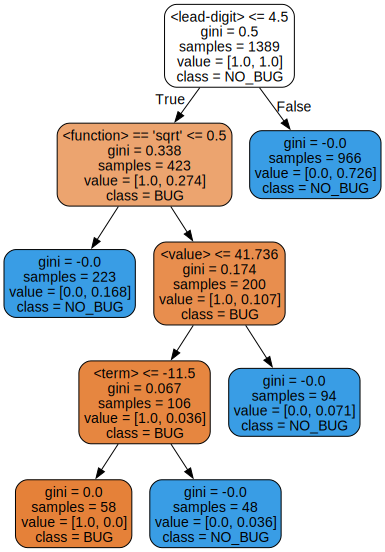

In [225]:
alhazen.show_decision_tree()

A decision tree is read from top to bottom.
Decision nodes (with two children) come with a _predicate_ on top.
This predicate is either

* _numeric_, such as `<value> > 20`, indicating the numeric value of the given symbol, or
* _existential_, such as `<digit> == '1'`, which has a _negative_ value when False, and a _positive_ value when True.

If the predicate evaluates to `True`, follow the left path; if it evaluates to `False`, follow the right path.
A leaf node (no children) will give you the final decision `class = BUG` or `class = NO_BUG`.

So if the predicate states `<function> == 'sqrt' <= 0.5`, this means that

* If the function is _not_ `sqrt` (the predicate `<function> == 'sqrt'` is negative, see above, and hence less than 0.5), follow the left (`True`) path.
* If the function _is_ `sqrt` (the predicate `<function> == 'sqrt'` is positive), follow the right (`False`) path.

The `samples` field shows the number of sample inputs that contributed to this decision.
The `gini` field (aka Gini impurity) indicates how many samples fall into the displayed class (`BUG` or `NO_BUG`).
A `gini` value of `0.0` means _purity_ - all samples fall into the displayed class.
The _saturation_ of nodes also indicates purity – the higher the saturation, the higher the purity.

There is also a text version available, with much fewer (but hopefully still essential) details:

In [226]:
print(alhazen.friendly_decision_tree())

if <lead-digit> <= 4.5000:
  if <function> == 'sqrt':
    if <value> <= 41.7355:
      if <term> <= -11.5000:
        BUG
      else:
        NO_BUG
    else:
      NO_BUG
  else:
    NO_BUG
else:
  NO_BUG



In both representations, we see that the present failure is associated with a negative value for the `sqrt` function and precise boundaries for its value.
In fact, the error conditions are given in the source code:

In [227]:
import inspect

In [228]:
print(inspect.getsource(task_sqrt))

def task_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    if x <= -12 and x >= -42:
        x = 0  # Guess where the bug is :-)
    else:
        x = 1
    x = max(x, 0)
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx



Try out Alhazen on your own code and your own examples!

## Lessons Learned

* Training _machine learners from input features_ can give important insights on failure circumstances.
* Generating _additional inputs_ based on feedback from the machine learner can greatly enhance precision.
* Applying machine learners on input and execution features is still at its infancy.

## Next Steps

Our [next chapter](Repairer.ipynb) introduces _automated repair_ of programs, building on the fault localization and generalization mechanisms introduced so far.

## Background

This chapter is built on the Alhazen paper by Kampmann et al. \cite{Kampmann2020}.

In \cite{Eberlein2023}, Eberlein et al. introduced _Avicenna_, a new interpretation of Alhazen that makes use of the ISLa framework \cite{Steinhoefel2022} to learn and produce input features.
Avicenna improves over Alhazen in terms of performance, expressiveness, and precision.